## Downloading and Importing Dependencies

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.5 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Data Preprocessing

In [ ]:
# Connect to my Drive to upload data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read data
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
#Convert target column binary classification
df['sentiment']=df['sentiment'].apply(lambda x: 0 if x=='negative' else 1)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [ ]:
#Change reviews to lower case
df['review'] = df['review'].str.lower()

In [ ]:

df['review'] =df['review'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x))
# Applying a lambda function to each element in the 'review' column
# The lambda function takes an element 'x' and performs a regular expression substitution
# The regular expression pattern 'r'[^a-zA-Z]' matches any non-letter character
# The re.sub() function substitutes the matched pattern with a space ' '


In [ ]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is...,1


In [ ]:
df.shape

(50000, 2)

# Stratified sampling data

 I am working on colab ,thus I have limited GPU and resources which disables me to process all 50000 review .So I applied Stratifies sampling on the data to random sample 200 positive samples and 200 negative samples.Which will result of a balanced data set.

In [ ]:
# Split the data into positive and negative categories
positive_data = df[df['sentiment'] == 1]
negative_data = df[df['sentiment'] == 0]

#Stratified sampling
positive_sample = positive_data.sample(n=200, random_state=42)
negative_sample = negative_data.sample(n=200, random_state=42)

# Concatenate the samples
df= pd.concat([positive_sample, negative_sample])

# BERT

In [ ]:
# Load the pre-trained BERT model and tokenizer
model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# Tokenize and encode the reviews in batches because of limited resources
max_length = 256  # Set the maximum sequence length
encoded_reviews = tokenizer.batch_encode_plus(
    df['review'].tolist(),
    add_special_tokens=True,
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_attention_mask=True,
    return_tensors='tf'
)

input_ids = encoded_reviews['input_ids']
attention_masks = encoded_reviews['attention_mask']

In [ ]:
#Generating context word embedding
embeddings = model(input_ids, attention_mask=attention_masks)[0]

In [ ]:
# Convert the embeddings and labels to NumPy arrays
X = embeddings.numpy()
y = df['sentiment'].values


In [ ]:
# Split the data into training, validation, and testing sets
from sklearn.model_selection import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),  # Flattens the input to a 1D array
    tf.keras.layers.Dense(150, activation='relu'),  # Fully connected layer with 150 neurons and ReLU activation
    tf.keras.layers.Dropout(0.2),  # Dropout regularization to randomly disable 20% of the neurons
    tf.keras.layers.Dense(100, activation='relu'),  # Fully connected layer with 100 neurons and ReLU activation
    tf.keras.layers.Dropout(0.2),  # Dropout regularization to randomly disable 20% of the neurons
    tf.keras.layers.Dense(50, activation='relu'),  # Fully connected layer with 50 neurons and ReLU activation
    tf.keras.layers.Dropout(0.2),  # Dropout regularization to randomly disable 20% of the neurons
    tf.keras.layers.Dense(25, activation='relu'),  # Fully connected layer with 25 neurons and ReLU activation
    tf.keras.layers.Dropout(0.2),  # Dropout regularization to randomly disable 20% of the neurons
    tf.keras.layers.Dense(20, activation='relu'),  # Fully connected layer with 20 neurons and ReLU activation
    tf.keras.layers.Dropout(0.2),  # Dropout regularization to randomly disable 20% of the neurons
    tf.keras.layers.Dense(10, activation='relu'),  # Fully connected layer with 10 neurons and ReLU activation
    tf.keras.layers.Dropout(0.2),  # Dropout regularization to randomly disable 20% of the neurons
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 neuron and sigmoid activation for binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Compiles the model with binary crossentropy loss and Adam optimizer
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))  # Trains the model for 200 epochs with a batch size of 32, using validation data for evaluation


Epoch 1/200
10/10 [==============================] - 6s 72ms/step - loss: 3.3548 - accuracy: 0.4938 - val_loss: 1.1909 - val_accuracy: 0.4500
Epoch 2/200
10/10 [==============================] - 0s 30ms/step - loss: 2.6350 - accuracy: 0.4719 - val_loss: 0.6955 - val_accuracy: 0.5125
Epoch 3/200
10/10 [==============================] - 0s 30ms/step - loss: 1.8733 - accuracy: 0.5312 - val_loss: 0.7120 - val_accuracy: 0.6000
Epoch 4/200
10/10 [==============================] - 0s 30ms/step - loss: 1.5799 - accuracy: 0.4906 - val_loss: 0.7762 - val_accuracy: 0.5125
Epoch 5/200
10/10 [==============================] - 0s 30ms/step - loss: 1.2440 - accuracy: 0.5125 - val_loss: 0.6964 - val_accuracy: 0.5500
Epoch 6/200
10/10 [==============================] - 0s 30ms/step - loss: 1.2483 - accuracy: 0.5188 - val_loss: 0.7096 - val_accuracy: 0.4750
Epoch 7/200
10/10 [==============================] - 0s 29ms/step - loss: 0.9358 - accuracy: 0.5063 - val_loss: 0.7411 - val_accuracy: 0.4500
Epoch 

In [ ]:
_, accuracy = model.evaluate(X_test, y_test)  # Evaluate the model on the test data and store the loss and accuracy values
print('Test Accuracy:', accuracy)  # Print the test accuracy value


2/2 [==============================] - 0s 16ms/step - loss: 1.3402 - accuracy: 0.8167
Test Accuracy: 0.8166666626930237


              precision    recall  f1-score   support

           0       0.81      0.78      0.79        27
           1       0.82      0.85      0.84        33

    accuracy                           0.82        60
   macro avg       0.82      0.81      0.81        60
weighted avg       0.82      0.82      0.82        60



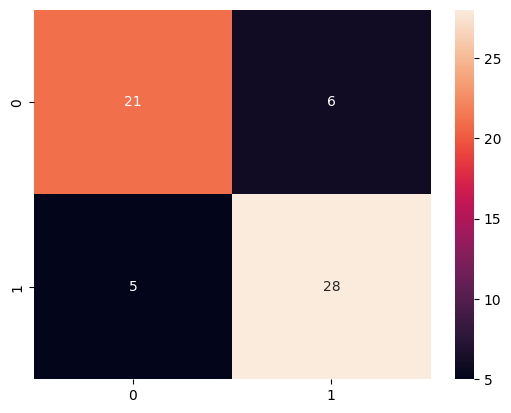

In [ ]:
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Convert predicted probabilities to binary labels
binary_pred = np.where(pred >= 0.5, 1, 0)

# Print classification report and visualize the confusion matrix
print(metrics.classification_report(y_test, binary_pred))
sns.heatmap(confusion_matrix(y_test, binary_pred), annot=True, fmt='d')
plt.show()
